# AIPI 590 - XAI | Assignment 07

Description: In this assignment we will analyze the embedding space of the [ember-v1](https://huggingface.co/llmrails/ember-v1) embedding model from hugging face. This model was chosen because it is a small model that is also straight forward. Many of the models on the leaderboard, like the cde-small-v1, for instance, provide contextual embedding which makes it difficult to visualize the embedding space since the input is actually a context window. The ember space should be sufficiently simple to visualize.

John Coogan

## Setup

In [1]:
%%capture 
!pip install --upgrade pip && pip install scikit-learn umap-learn transformers einops numpy torch matplotlib

In [2]:
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import torch
import matplotlib.pyplot as plt
import random


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Load

In [3]:
# %%capture
# model = transformers.AutoModel.from_pretrained("jxm/cde-small-v1", trust_remote_code=True)
# tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased") #from hugginface notebook example: https://colab.research.google.com/drive/1r8xwbp7_ySL9lP-ve4XMJAHjidB9UkbL?usp=sharing#scrollTo=gd2u97r6nkfG

In [4]:
tokenizer = AutoTokenizer.from_pretrained("llmrails/ember-v1")
model = AutoModel.from_pretrained("llmrails/ember-v1")

## Vocabulary processing to embeddings

The tokenizer comes with a vocabulary associated with ids, the ids are what is passed to the embedding model to convert them into large vectors (dim 768). We can then apply dimensionality reduction techniques to view this space in two dimensions

In [5]:
vocab = tokenizer.get_vocab()
print(vocab)

{'cornice': 27848, '##woman': 10169, 'contemporaries': 16682, 'rectory': 24606, 'trains': 4499, 'shortest': 20047, 'edison': 17046, 'barracks': 10492, 'periodicals': 21855, 'dramatically': 12099, 'tolkien': 23602, '##龍': 30508, '##pha': 21890, 'ashamed': 14984, 'liang': 16982, 'accolades': 27447, 'eu': 7327, '[unused690]': 695, 'evil': 4763, 'determined': 4340, 'neurological': 23130, 'view': 3193, '##ignon': 24796, '30': 2382, 'zhou': 14367, '##ton': 2669, 'surround': 15161, '1935': 4437, 'amendments': 16051, 'labyrinth': 24239, 'minorities': 14302, 'wryly': 28325, 'edges': 7926, '##outs': 12166, 'fortress': 7841, 'spa': 12403, '##oping': 17686, 'zev': 27909, 'cartridges': 22998, 'tun': 27112, '##dened': 24589, 'brighter': 16176, 'smiling': 5629, 'hinted': 21795, '70': 3963, 'vocalist': 8032, 'healing': 8907, '[unused451]': 456, '##enes': 28553, 'ill': 5665, '##chio': 23584, '2003': 2494, 'posting': 14739, 'responsive': 26651, 'thrust': 7400, '[unused960]': 965, '##ilised': 21758, 'mon

Above we can see the bert-base-uncased vocabulary. Below wer will parse this into lists of ids and words. The actual vocabulary is 30,522 words long so we will take a random sample for easier visualization.

In [17]:
random.seed(42)

#number of samples:
n = 800

vocab_words_full = list(vocab.keys())
vocab_ids_full = list(vocab.values())

random_indices = random.sample(range(len(vocab_words_full)),n)

vocab_words = [vocab_words_full[i] for i in random_indices]
vocab_ids = [vocab_ids_full[i] for i in random_indices]

print(f"First three vocabulary words {vocab_words[:3]}")
print(f"First three ids {vocab_ids[:3]}")

First three vocabulary words ['stamps', 'shame', 'factual']
First three ids [12133, 9467, 25854]


Now we will convert the ids to embeddings:


In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
#.numpy() needs to be on cpu so we wont load the model to GPU
with torch.no_grad():
    embeddings = model.embeddings.word_embeddings.weight[vocab_ids].cpu().numpy()


### Plot Function

In [19]:
def plot_embeddings(embeddings, title, vocab_words,n):
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', marker='o')
    for i, word in enumerate(vocab_words):
        if i%10==0: #lets try to plot every 10th word to avoid clutter
            plt.annotate(word, (embeddings[i, 0], embeddings[i, 1]), fontsize=9)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(f"images/{title}{n}.png")
    plt.show()

## t-SNE

In [20]:
tsne = TSNE(n_components=2,random_state=2)
embeddings_tsne = tsne.fit_transform(embeddings)

/tmp/ipykernel_38626/1880851672.py:10: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/{title}{n}.png")
/tmp/ipykernel_38626/1880851672.py:10: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/{title}{n}.png")
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


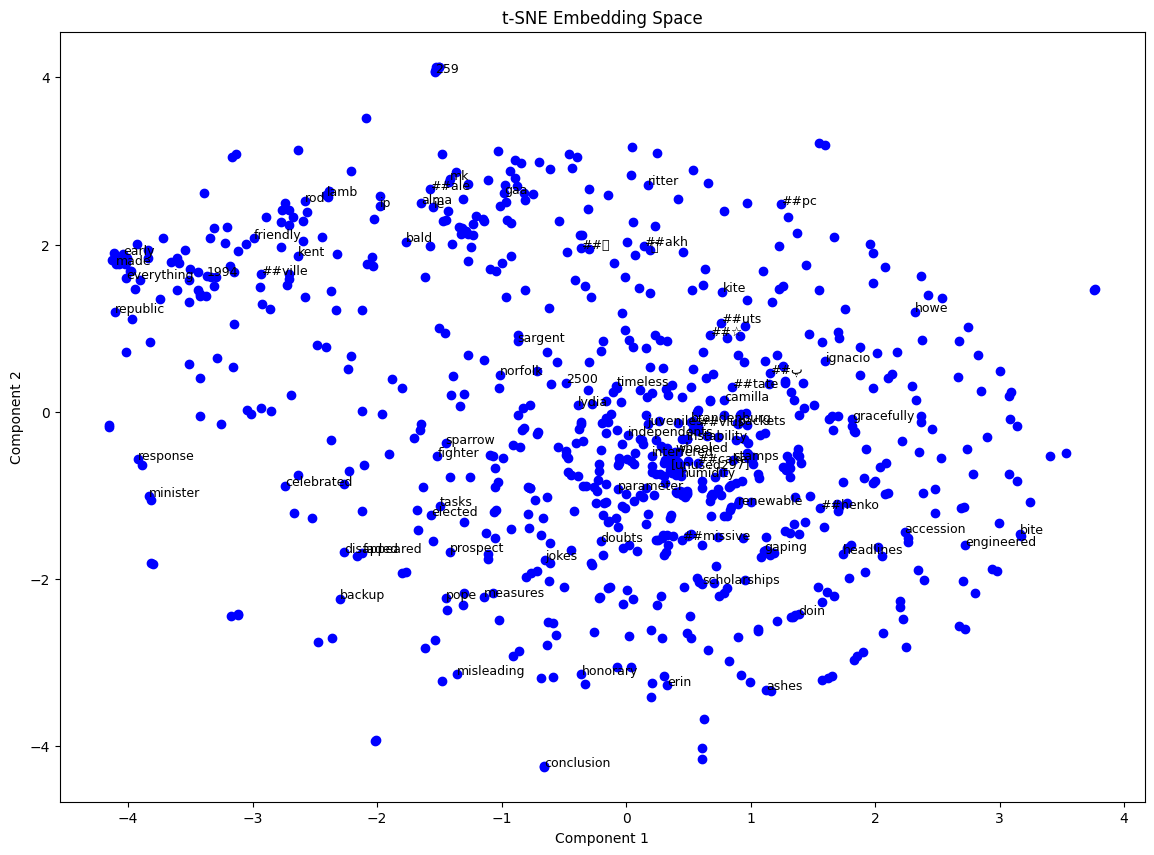

In [21]:
plot_embeddings(embeddings_tsne,"t-SNE Embedding Space",vocab_words,n)


## PCA

In [22]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

/tmp/ipykernel_38626/1880851672.py:10: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/{title}{n}.png")
/tmp/ipykernel_38626/1880851672.py:10: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/{title}{n}.png")
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


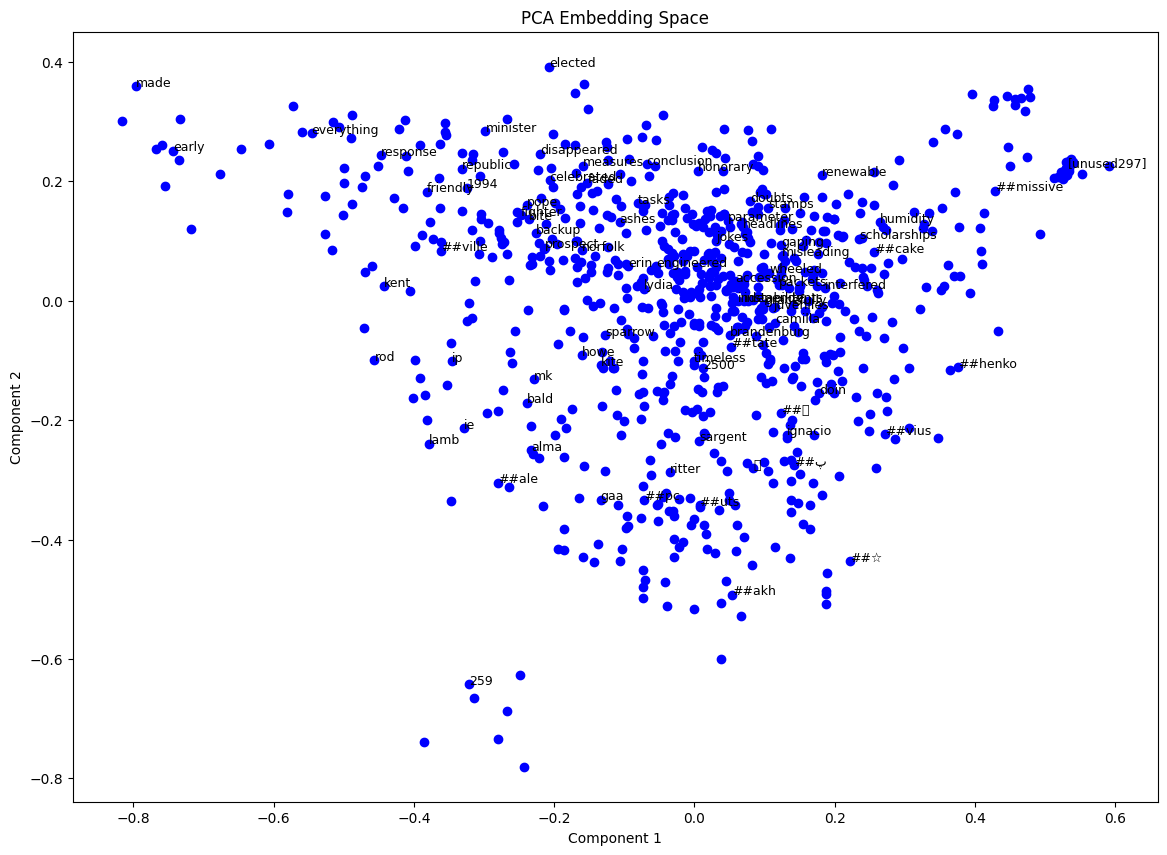

In [23]:
plot_embeddings(embeddings_pca,"PCA Embedding Space",vocab_words,n)

## UMAP

In [24]:
umap_model = umap.UMAP(n_components=2)
embeddings_umap = umap_model.fit_transform(embeddings)

/tmp/ipykernel_38626/1880851672.py:10: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/{title}{n}.png")
/tmp/ipykernel_38626/1880851672.py:10: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/{title}{n}.png")
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


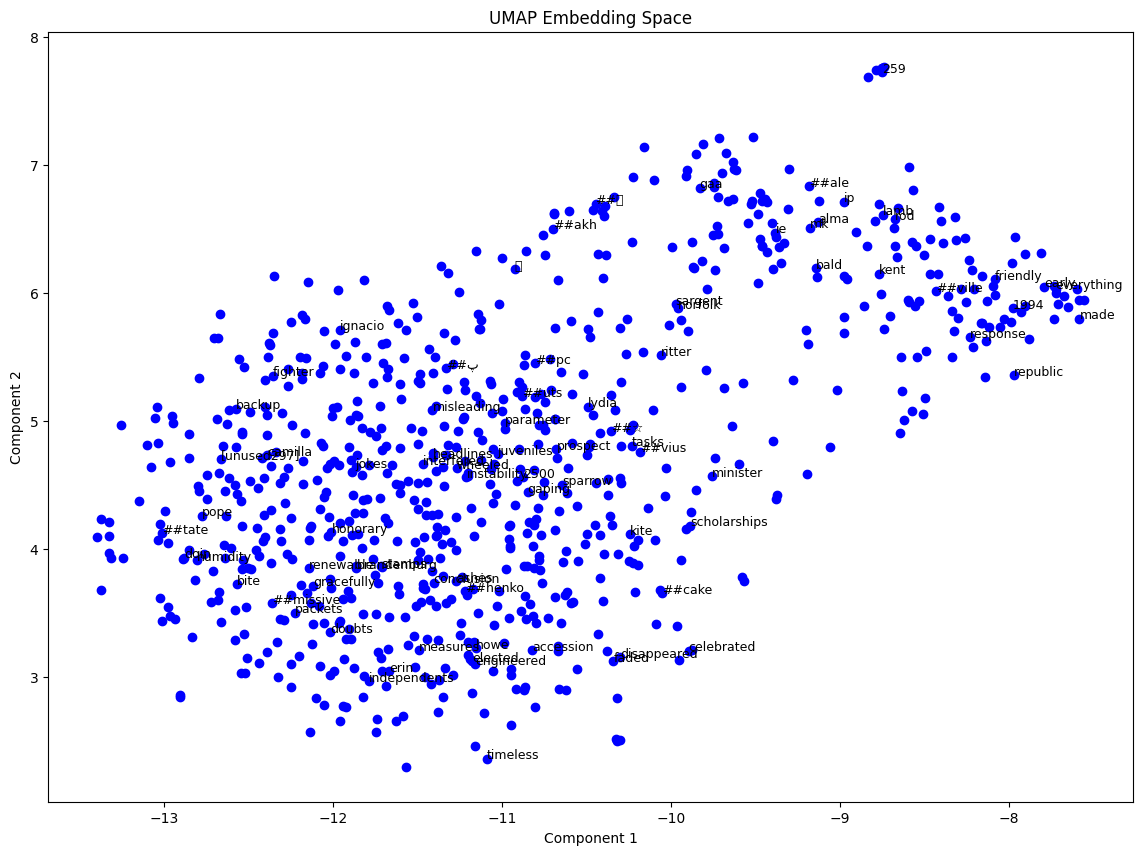

In [25]:
plot_embeddings(embeddings_umap,"UMAP Embedding Space",vocab_words,n)

## Discussion

<table>
  <tr>
    <td>200 Words</td>
    <td>
      <p align="center">
        <img src="images/t-SNE Embedding Space.png" alt="Image 1" width="30%" />
        <img src="images/PCA Embedding Space.png" alt="Image 2" width="30%" />
        <img src="images/UMAP Embedding Space.png" alt="Image 3" width="30%" />
      </p>
    </td>
  </tr>
  <tr>
    <td>400 Words</td>
    <td>
      <p align="center">
        <img src="images/t-SNE Embedding Space400.png" alt="Image 4" width="30%" />
        <img src="images/PCA Embedding Space400.png" alt="Image 5" width="30%" />
        <img src="images/UMAP Embedding Space400.png" alt="Image 6" width="30%" />
      </p>
    </td>
  </tr>
  <tr>
    <td>800 Words</td>
    <td>
      <p align="center">
        <img src="images/t-SNE Embedding Space800.png" alt="Image 7" width="30%" />
        <img src="images/PCA Embedding Space800.png" alt="Image 8" width="30%" />
        <img src="images/UMAP Embedding Space800.png" alt="Image 9" width="30%" />
      </p>
    </td>
  </tr>
</table>

We can see some interesting findings with these embedding spaces but first, to point out the obvious. Ember-v1 utilizes an embedding dimension of 1024 and each of these dimensionality reduction techniques is compressing those dimensions down to 2 via different methods. In this regard, what we are looking at is the information (or patterns) that is retained after this process in these plots. With that in mind we can see that t-SNE results in almost total information loss, each dot is nearly perfectly spaced from each other indicated that semantic relationships between words in the embedding space no longer exist or are poorly defined. Within this vector space, t-SNE is not a good option for the preservation of information. Our best candidate (presumably) by virtue of the preservation of spatial structures for compression with semantic retention would probably be PCA given that it has the best defined structures remaining in dimension 2. UMAP appears to be a middle ground between the two. 

We can also see in the progession of the number of words selected from the vocabulary that PCA and t-SNE retain or improve definition of spatial structures while UMAP is highly variable. This is interesting because, if the distribution of words in the embedding space adhered to a pattern (PCA) then randomly selecting a larget portion should hold that pattern but UMAP variations difer wildly. 